# ０～９までの数字の画像からどの数字なのかを推論する畳み込みニューラルネットワーク（CNN）モデルの構築

#### データセットの準備

In [1]:
from datasets import load_dataset
ds = load_dataset("ylecun/mnist")

c:\Users\uenoj\MyPython\deep-learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

#### データセットの確認

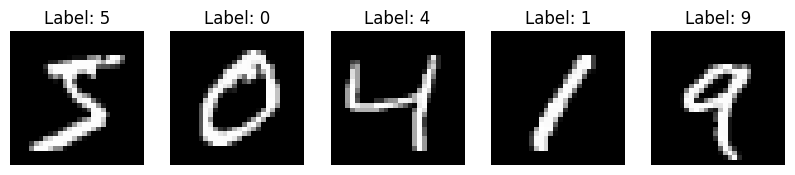

In [3]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    image = ds['train'][i]['image']
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {ds['train'][i]['label']}")
    ax.axis('off')
plt.show()

In [4]:
ds['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

In [5]:
print(f"画像サイズ {image.size}")

画像サイズ (28, 28)


In [6]:
# 型の変換
ds.set_format(type='torch', columns=['image', 'label'])

#### 畳み込みニューラルネットワークのモデルを定義

In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPUを使用します")
else:
    device = torch.device("cpu")
    print("CPUを使用します")
print(device)

GPUを使用します
cuda


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # x = x.view(-1, 64)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


##### モデルの動作確認

In [9]:
# 1つ目のデータを取得
train_loader = torch.utils.data.DataLoader(ds['train'])
data_iter = iter(train_loader)
batch = next(data_iter)
images, labels = batch['image'], batch['label']
print(images.size())
print(labels)

torch.Size([1, 1, 28, 28])
tensor([5])


In [10]:
# 1つ目のデータをモデルに入力
pred = model(images.squeeze(2).float())
print(f"output shape: {pred.shape}")
print(pred.min(), pred.max())
print(pred)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

#### 損失関数とオプティマイザーを設定

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### モデルを訓練

In [18]:
targets = ds['train']['label'].numpy()
class_counts = np.bincount(targets)
class_weights = 1 / class_counts
sample_weights = class_weights[targets]

sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [19]:
# データローダーの作成
train_loader = torch.utils.data.DataLoader(ds['train'], batch_size=64, sampler=sampler)

# モデルの訓練
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data['image'], data['label']
        inputs = inputs.squeeze(2).float().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f"predicted: {predicted}")
        print(f"labels: {labels}")
        print(f"Epoch {epoch+1}, Iteration {i+1}, Loss: {running_loss / (i+1)}, Accuracy: {100 * correct / total}")
        print("---------------------------------------------")

print('Finished Training')

predicted: tensor([2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 5, 4, 5, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 4, 2, 5, 2, 2, 4, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 4,
        2, 2, 2, 5, 2, 4, 2, 2, 2, 2, 2, 2, 5, 4, 4, 2], device='cuda:0')
labels: tensor([0, 9, 7, 9, 3, 5, 6, 2, 0, 9, 6, 5, 2, 0, 6, 8, 2, 3, 7, 8, 3, 8, 5, 2,
        4, 8, 8, 6, 9, 5, 2, 0, 3, 0, 4, 6, 3, 2, 9, 9, 8, 4, 0, 0, 9, 9, 8, 1,
        4, 7, 6, 7, 8, 3, 3, 9, 8, 9, 7, 1, 2, 1, 5, 9], device='cuda:0')
Epoch 1, Iteration 1, Loss: 2.328878164291382, Accuracy: 3.125
---------------------------------------------
predicted: tensor([4, 2, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 4, 4, 4, 2, 2, 2, 7, 2, 2, 2, 2,
        2, 7, 2, 2, 2, 5, 5, 4, 2, 2, 5, 2, 4, 4, 2, 4, 2, 2, 5, 4, 2, 4, 2, 4,
        2, 2, 2, 2, 2, 2, 7, 4, 2, 4, 2, 2, 2, 2, 4, 2], device='cuda:0')
labels: tensor([4, 7, 4, 4, 9, 3, 0, 3, 3, 0, 1, 0, 3, 3, 9, 5, 4, 3, 1, 3, 3, 9, 1, 3,
        3, 3, 4, 6, 4, 8, 0, 2, 3, 7, 7, 4, 1, 7, 3, 4, 2, 8, 5, 1, 6, 

In [22]:
len(predicted)

32

In [23]:
len(labels)

32

#### 評価

In [23]:
model.eval()
correct = 0

test_loader = torch.utils.data.DataLoader(ds['train'], batch_size=1, shuffle=False)

predicts_list = []
labels_list = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data['image'], data['label']
        images = images.squeeze(2).float().to(device)
        labels = labels.to(device)
        outpts = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        predicts_list.extend(predicted)
        labels_list.extend(labels)
        print(f"output shape: {outputs.shape}")
        print(f"predicted: {predicted}\nactual: {labels}")
        print(f"Accuracy: {100 * correct / len(predicts_list):.2f}%")
        print("-----------------------------------------------------------------")

output shape: torch.Size([32, 10])
predicted: tensor([4, 8, 5, 2, 2, 5, 0, 8, 8, 4, 6, 2, 8, 3, 2, 9, 6, 2, 4, 5, 3, 6, 8, 8,
        3, 7, 4, 2, 5, 8, 9, 5], device='cuda:0')
actual: tensor([5], device='cuda:0')
Accuracy: 15.62%
---------------------------------------------
output shape: torch.Size([32, 10])
predicted: tensor([4, 8, 5, 2, 2, 5, 0, 8, 8, 4, 6, 2, 8, 3, 2, 9, 6, 2, 4, 5, 3, 6, 8, 8,
        3, 7, 4, 2, 5, 8, 9, 5], device='cuda:0')
actual: tensor([0], device='cuda:0')
Accuracy: 9.38%
---------------------------------------------
output shape: torch.Size([32, 10])
predicted: tensor([4, 8, 5, 2, 2, 5, 0, 8, 8, 4, 6, 2, 8, 3, 2, 9, 6, 2, 4, 5, 3, 6, 8, 8,
        3, 7, 4, 2, 5, 8, 9, 5], device='cuda:0')
actual: tensor([4], device='cuda:0')
Accuracy: 10.42%
---------------------------------------------
output shape: torch.Size([32, 10])
predicted: tensor([4, 8, 5, 2, 2, 5, 0, 8, 8, 4, 6, 2, 8, 3, 2, 9, 6, 2, 4, 5, 3, 6, 8, 8,
        3, 7, 4, 2, 5, 8, 9, 5], device='cuda:0

KeyboardInterrupt: 

In [24]:
print(f"predicts: {predicts_list[:10]}")
print(f"labels: {labels_list[:10]}")

NameError: name 'predicts_list' is not defined

##### ヒートマップでビジュアライズ

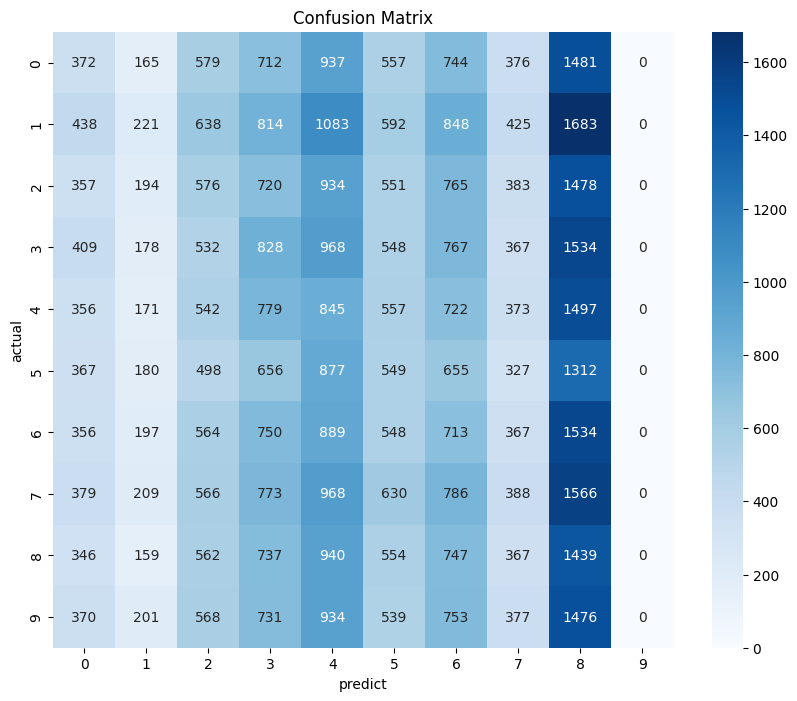

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ensure both lists have the same length
preds_list = preds_list[:len(actuals_list)]

cm = confusion_matrix(actuals_list, preds_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("predict")
plt.ylabel("actual")
plt.show()